In [381]:
using LinearAlgebra
using Plots
# using Zygote
# using Roots
using LaTeXStrings
using Interpolations
using DataFrames
using CSV
using Printf
using LsqFit
using ColorSchemes

In [382]:
# global constants...

const vF::Float64 = 1e8 # cm/s
const r_LA::Float64 = 0.021 # vS/vF
# note: in this code I use r = vS/vF and s = vD/vS

const L::Float64 = 13 # μm
const W::Float64 = 3 # μm
const ρ::Float64 = 7.63e-8 # g cm^-2 

const n_flavors::Int32 = 4

const ergs_per_eV::Float64 = 1.602e-12

const D::Float64 = 19 * ergs_per_eV # 19 eV, converted to ergs

const e_statC::Float64 = -4.80326e-10 # statC
const e_C::Float64 = -1.60217663e-19 # coulombs

const ħ_eV_s::Float64 = 6.582e-16 # eV*s
const kB_eV_K::Float64 = 8.617e-5 # eV/K

const cutoff_angle::Float64 = 2*π


# the device is 3 μm wide and 13 μm long.
# the contacts are 1 μm wide and there is 1 μm spacing between them,
# so the center-to-center distance is 2 μm.
# the centers of the contacts are, I think, 1.5, 3.5, 5.5, 7.5, 9.5, 11.5 μm.

6.283185307179586

In [383]:
function load_field_vals_2K(n,x)
    T_str = @sprintf("%1.2e",2.0)
    n_str = @sprintf("%1.2e",n)
    x_str = @sprintf("%1.2e",x)
    field_df = DataFrame(CSV.File("./field_vals_csv/D_19_eV/2K/" * replace("T="*T_str*"_n="*n_str*"_x="*x_str, "."=>"-") * ".csv"))
    return field_df
end

load_field_vals_2K (generic function with 1 method)

In [384]:
x_vals_μm = 0.0:0.5:12.0 # μm
x_vals_m = collect(x_vals_μm) .* 1e-6 # meters

T::Float64 = 2.0 # K
n::Float64 = 1.4e12 # cm^-2


field_dfs = []
for x in x_vals_μm
    push!(field_dfs, load_field_vals_2K(n,x))
end

s_vals = field_dfs[1][:,1]

fields_matrix = hcat([df_x[:,2] for df_x in field_dfs]...)
# row corresponds to s, column corresponds to x

81×25 Matrix{Float64}:
    0.00254452     0.00228956      0.00205422  …  -0.00183315  -0.00205422
    0.0121006      0.0114736       0.0109021       0.00577379   0.00575736
    0.0248977      0.0237457       0.0226882       0.0135343    0.0135916
    0.0415735      0.039728        0.0380244       0.0228259    0.0229088
    0.0669065      0.0640422       0.0613807       0.0357452    0.0357164
    0.109665       0.105078        0.100783    …   0.0550752    0.0546334
    0.19198        0.184312        0.177072        0.0922218    0.0907551
    0.377608       0.364059        0.351162        0.186034     0.182184
    0.899946       0.873224        0.847531        0.483312     0.472705
    2.72082        2.66905         2.6187          1.8176       1.7897
    ⋮                                          ⋱               
 3025.35        6624.82        14998.7             2.80926e12   7.13394e12
 3083.08        6838.88        15704.0             4.11269e12   1.0613e13
 3141.17        7060.07    

first we look at the electric field,

In [385]:
plot_indices = 8:18

8:18

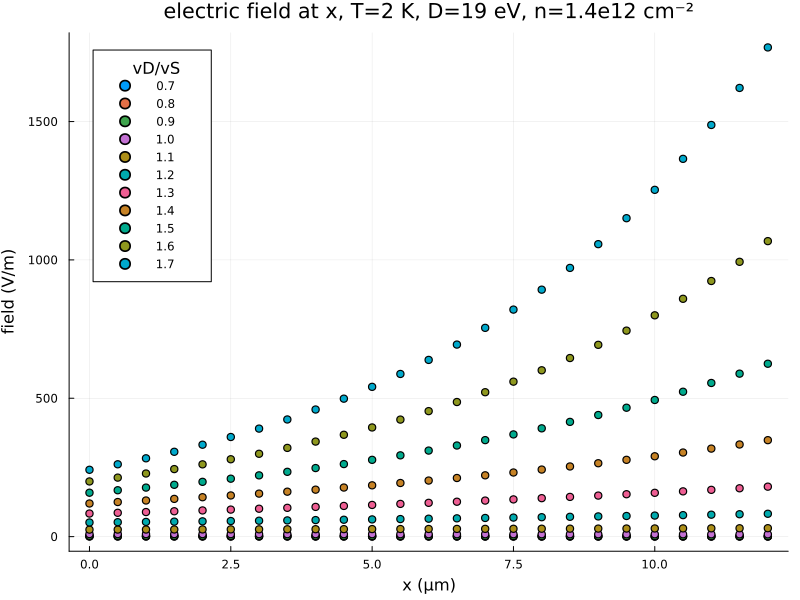

In [386]:
p1 = scatter(x_vals_μm, ([eachrow(fields_matrix)...])[plot_indices], labels=hcat(s_vals[plot_indices]...))
p1 = plot!(xlabel = "x (μm)", ylabel = "field (V/m)", title = "electric field at x, T=2 K, D=19 eV, n=1.4e12 cm⁻²", legendtitle="vD/vS")
p1 = plot!(size=(800,600))

on a log scale,

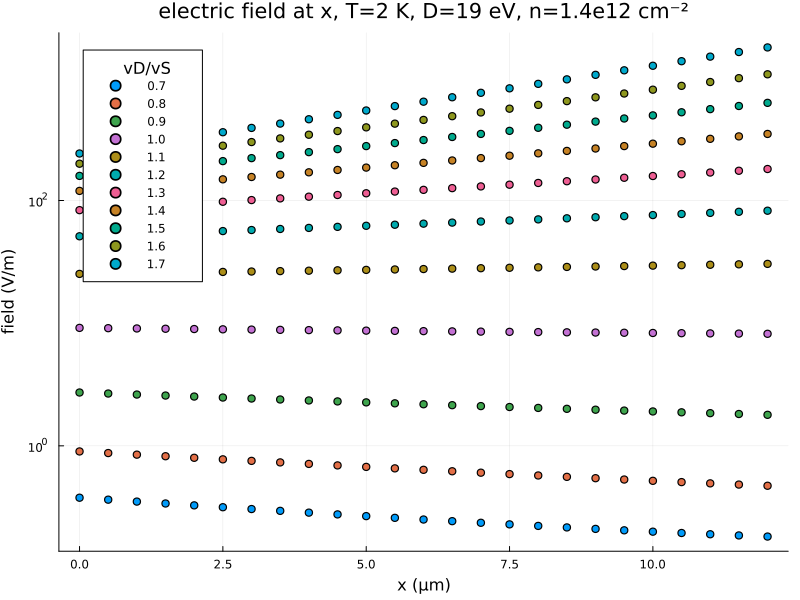

In [387]:
p2 = scatter(x_vals_μm, ([eachrow(fields_matrix)...])[plot_indices], labels=hcat(s_vals[plot_indices]...))
p2 = plot!(xlabel = "x (μm)", ylabel = "field (V/m)", title = "electric field at x, T=2 K, D=19 eV, n=1.4e12 cm⁻²", legendtitle="vD/vS", yaxis=:log)
p2 = plot!(size=(800,600))

In [388]:
log_with_nan(x) = (x ≤ 0)||isinf(x) ? NaN : log(x)

log_with_nan (generic function with 1 method)

In [389]:
log_fields = log_with_nan.(fields_matrix)

81×25 Matrix{Float64}:
 -5.97381   -6.07939   -6.18786   …  NaN         NaN         NaN
 -4.4145    -4.46771   -4.5188        -5.14853    -5.15443    -5.15728
 -3.69298   -3.74036   -3.78591       -4.30337    -4.30253    -4.2983
 -3.18029   -3.2257    -3.26953       -3.78008    -3.77986    -3.77623
 -2.70446   -2.74821   -2.79066       -3.32733    -3.33134    -3.33214
 -2.21032   -2.25305   -2.29479   …   -2.88814    -2.89906    -2.90711
 -1.65036   -1.69113   -1.7312        -2.36531    -2.38356    -2.39959
 -0.973899  -1.01044   -1.04651       -1.65953    -1.68183    -1.70274
 -0.105421  -0.135563  -0.165428      -0.704247   -0.727093   -0.749284
  1.00093    0.981723   0.962679       0.613215    0.597515    0.582048
  ⋮                               ⋱                          
  8.01478    8.79858    9.61572       27.7329     28.6639     29.5959
  8.03369    8.83038    9.66167       28.098      29.0451     29.9931
  8.05235    8.86221    9.7079        28.4641     29.4273     30.3914


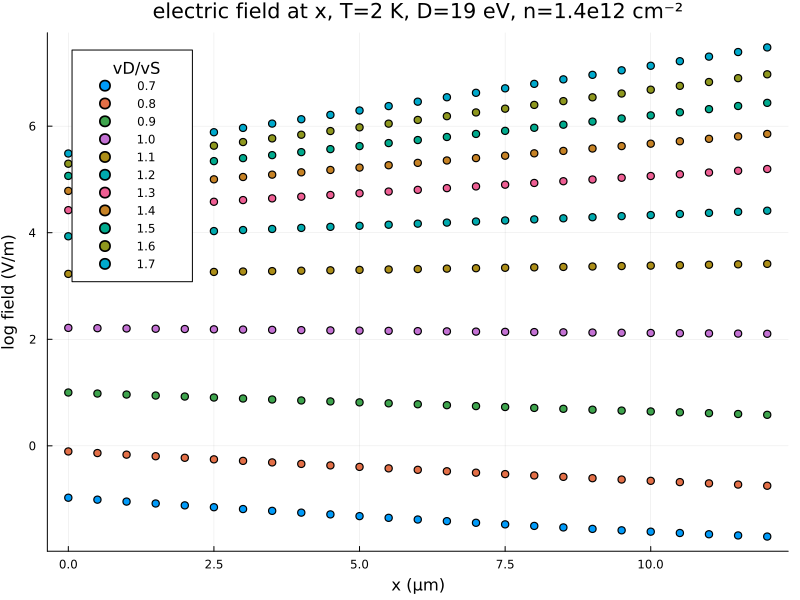

In [390]:
p3 = scatter(x_vals_μm, ([eachrow(log_fields)...])[plot_indices], labels=hcat(s_vals[plot_indices]...))
p3 = plot!(xlabel = "x (μm)", ylabel = "log field (V/m)", title = "electric field at x, T=2 K, D=19 eV, n=1.4e12 cm⁻²", legendtitle="vD/vS")
p3 = plot!(size=(800,600))

In [391]:
model(x,p) = p[1] .+ p[2]*x

model (generic function with 1 method)

In [392]:
log_field_fit_params = Matrix{Float64}(undef,0,2)
log_field_fit_stdev = Matrix{Float64}(undef,0,2)
for (i,row) in enumerate(eachrow(log_fields))
    if any(isnan,row)
        log_field_fit_params = vcat(log_field_fit_params, [NaN,NaN]')
        log_field_fit_stdev = vcat(log_field_fit_stdev, [NaN,NaN]')
        continue
    end
    fit = curve_fit(model, x_vals_μm, row, [100.0, 3.0])
    log_field_fit_params = vcat(log_field_fit_params, fit.param')
    log_field_fit_stdev = vcat(log_field_fit_stdev, standard_errors(fit)')
end

In [393]:
x_finer_grid_μm = range(x_vals_μm[1], x_vals_μm[end], length=1000)

0.0:0.012012012012012012:12.0

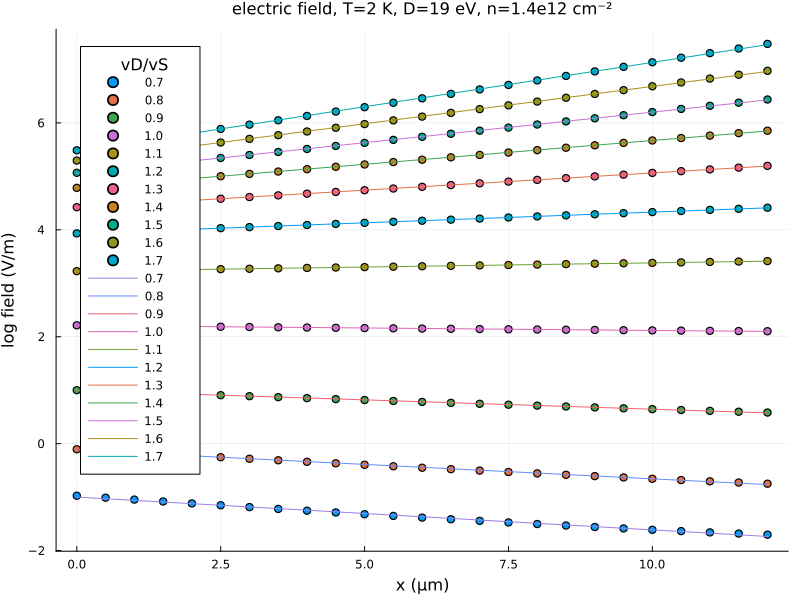

In [394]:
p4 = scatter(x_vals_μm, ([eachrow(log_fields)...])[plot_indices], labels=hcat(s_vals[plot_indices]...))

p4 = plot!(x_finer_grid_μm, [x -> model(x, log_field_fit_params[i,:]) for i=plot_indices], labels=hcat(s_vals[plot_indices]...))

p4 = plot!(xlabel = "x (μm)", ylabel = "log field (V/m)", title = "electric field, T=2 K, D=19 eV, n=1.4e12 cm⁻²", titlefontsize=11, legendtitle="vD/vS")
p4 = plot!(size=(800,600))

we can compute the resistivity by dividing the electric field by the current density,

In [395]:
function drift_velocity_to_current_density(n,s)
    # n in cm^-2, vD in cm/s
    # returns current in amperes
    vD = r_LA*s*vF
    # width_in_cm = W * 1e-4
    return n * e_C * vD
end

drift_velocity_to_current_density (generic function with 1 method)

In [396]:
current_densities = Float64[]
for s in s_vals
    push!(current_densities, abs(drift_velocity_to_current_density(n,s)))
end

In [397]:
function resistivity_matrix(fields_matrix, current_densities)
    r_matrix = similar(fields_matrix)
    for (i, F_row) in enumerate(eachrow(fields_matrix))
        r_matrix[i,:] = F_row ./ current_densities[i]
    end
    return r_matrix
end

resistivity_matrix (generic function with 1 method)

In [398]:
resistivities = resistivity_matrix(fields_matrix, current_densities)

81×25 Matrix{Float64}:
  Inf          Inf          Inf        …  -Inf          -Inf
   0.25689      0.243579     0.231447       0.122575      0.122227
   0.264284     0.252056     0.240831       0.143664      0.144272
   0.294197     0.281137     0.269081       0.161529      0.162115
   0.3551       0.339898     0.325772       0.189714      0.189562
   0.46563      0.446155     0.427916  …    0.233845      0.231969
   0.679277     0.652145     0.62653        0.326306      0.321116
   1.14521      1.10412      1.06501        0.564205      0.552529
   2.38819      2.31728      2.2491         1.28257       1.25442
   6.418        6.29588      6.17712        4.28743       4.22163
   ⋮                                   ⋱                
 892.041     1953.37      4422.45           8.28328e11    2.10348e12
 896.613     1988.86      4566.98           1.19604e12    3.08644e12
 901.16      2025.44      4718.43           1.72912e12    4.53445e12
 905.686     2062.56      4874.74      …    2.50272

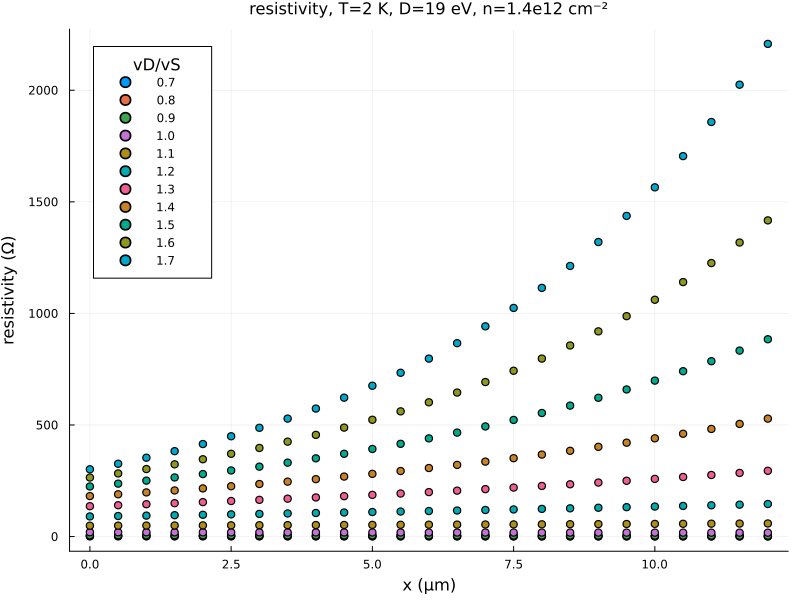

In [399]:
p5 = scatter(x_vals_μm, ([eachrow(resistivities)...])[plot_indices], labels=hcat(s_vals[plot_indices]...))
p5 = plot!(xlabel = "x (μm)", ylabel = "resistivity (Ω)", title = "resistivity, T=2 K, D=19 eV, n=1.4e12 cm⁻²", titlefontsize=11, legendtitle="vD/vS")
p5 = plot!(size=(800,600))

In [400]:
log_resistivities = log_with_nan.(resistivities)

81×25 Matrix{Float64}:
 NaN         NaN          NaN          …  NaN         NaN         NaN
  -1.35911    -1.41231     -1.4634         -2.09313    -2.09903    -2.10188
  -1.33073    -1.3781      -1.42366        -1.94112    -1.94028    -1.93605
  -1.22351    -1.26891     -1.31274        -1.8233     -1.82307    -1.81945
  -1.03536    -1.07911     -1.12156        -1.65823    -1.66224    -1.66304
  -0.764365   -0.807089    -0.848828   …   -1.44218    -1.4531     -1.46115
  -0.386726   -0.427488    -0.467559       -1.10167    -1.11992    -1.13595
   0.135588    0.0990486    0.0629804      -0.550039   -0.572338   -0.593249
   0.870535    0.840393     0.810528        0.271709    0.248863    0.226672
   1.85911     1.8399       1.82085         1.47139     1.45569     1.44022
   ⋮                                   ⋱                          
   6.79351     7.57731      8.39445        26.5116     27.4427     28.3746
   6.79862     7.59532      8.42661        26.8629     27.81       28.758
   6.

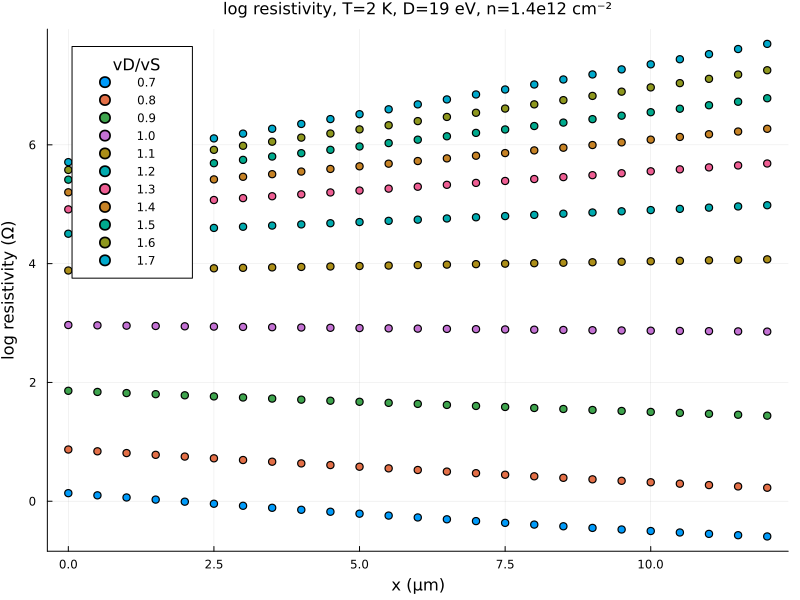

In [401]:
p6 = scatter(x_vals_μm, ([eachrow(log_resistivities)...])[plot_indices], labels=hcat(s_vals[plot_indices]...))
p6 = plot!(xlabel = "x (μm)", ylabel = "log resistivity (Ω)", title = "log resistivity, T=2 K, D=19 eV, n=1.4e12 cm⁻²", titlefontsize=11, legendtitle="vD/vS")
p6 = plot!(size=(800,600))

In [402]:
log_resistivity_fit_params = Matrix{Float64}(undef,0,2)
log_resistivity_fit_stdev = Matrix{Float64}(undef,0,2)
for (i,row) in enumerate(eachrow(log_resistivities))
    if any(isnan,row)
        log_resistivity_fit_params = vcat(log_resistivity_fit_params, [NaN,NaN]')
        log_resistivity_fit_stdev = vcat(log_resistivity_fit_stdev, [NaN,NaN]')
        continue
    end
    fit = curve_fit(model, x_vals_μm, row, [100.0, 3.0])
    log_resistivity_fit_params = vcat(log_resistivity_fit_params, fit.param')
    log_resistivity_fit_stdev = vcat(log_resistivity_fit_stdev, standard_errors(fit)')
end

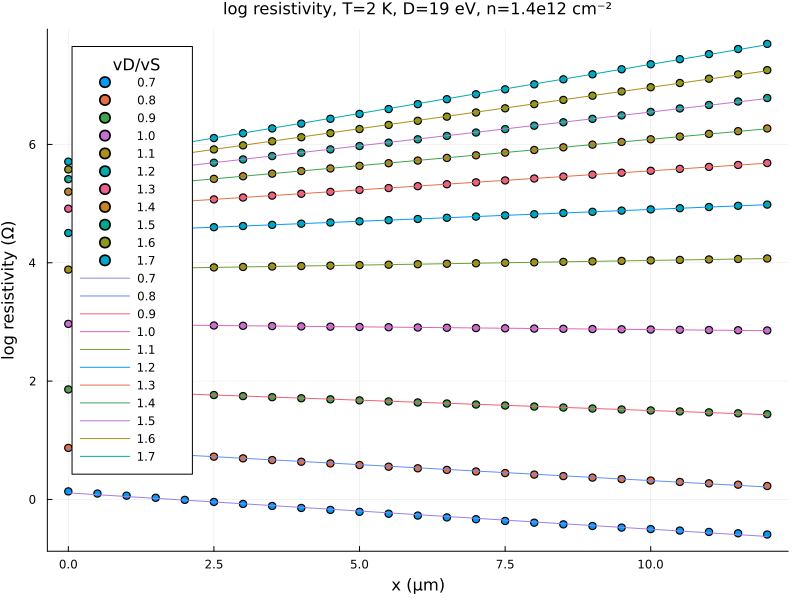

In [403]:
p7 = scatter(x_vals_μm, ([eachrow(log_resistivities)...])[plot_indices], labels=hcat(s_vals[plot_indices]...))

p7 = plot!(x_finer_grid_μm, [x -> model(x, log_resistivity_fit_params[i,:]) for i=plot_indices], labels=hcat(s_vals[plot_indices]...))

p7 = plot!(xlabel = "x (μm)", ylabel = "log resistivity (Ω)", title = "log resistivity, T=2 K, D=19 eV, n=1.4e12 cm⁻²", titlefontsize=11, legendtitle="vD/vS")
p7 = plot!(size=(800,600))

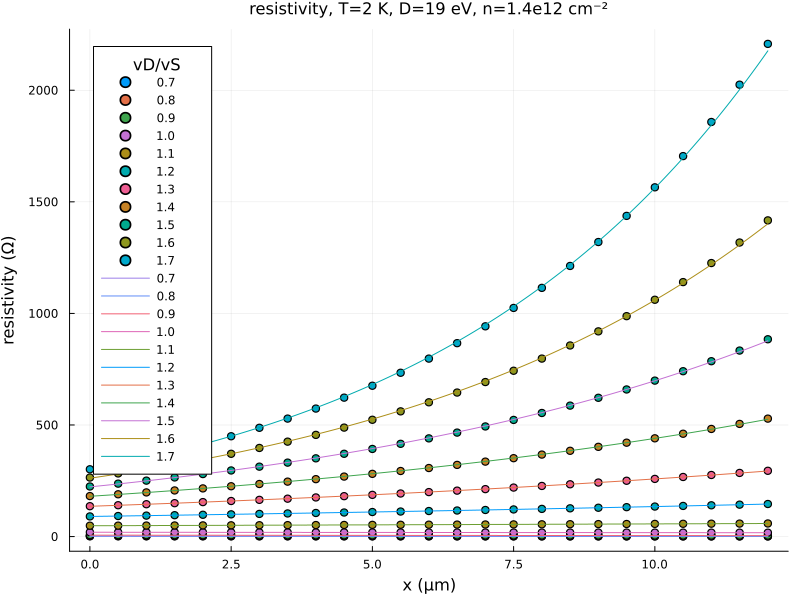

In [404]:
p7 = scatter(x_vals_μm, ([eachrow(resistivities)...])[plot_indices], labels=hcat(s_vals[plot_indices]...))

p7 = plot!(x_finer_grid_μm, [x -> exp(model(x, log_resistivity_fit_params[i,:])) for i=plot_indices], labels=hcat(s_vals[plot_indices]...))

p7 = plot!(xlabel = "x (μm)", ylabel = "resistivity (Ω)", title = "resistivity, T=2 K, D=19 eV, n=1.4e12 cm⁻²", titlefontsize=11, legendtitle="vD/vS")
p7 = plot!(size=(800,600))

now we add the plot of $\max \Gamma^{\textrm{amp}}_{\bf q} / v_\textrm{s}$ and the fit slope vs $v_\textrm{D}$

In [405]:
function load_γs_df_2K(n,s)
    T = 2.0
    T_str = @sprintf("%1.2e",T)
    n_str = @sprintf("%1.2e",n)
    s_str = @sprintf("%1.2e",s)
    return DataFrame(CSV.File("./amp_rates_csv/D_19_eV/2K/" * replace("T="*T_str*"_n="*n_str*"_s="*s_str, "."=>"-") * ".csv"))
end

function max_Gamma_amp_over_vs_2K(s)
    γs_df = load_γs_df_2K(n,s)
    Γamps = γs_df."Γamp"
    max_Γamp = maximum(Γamps) # this is in 1/s
    vS = r_LA*vF # this is in cm/s
    # max_Γamp / vS would be in 1/cm, so we need to multiply by 1 cm / 10^4 μm to get to 1/μm.
    return (max_Γamp / vS) * 1e-4
end

expected_slopes = [max_Gamma_amp_over_vs_2K(s) for s in s_vals]

81-element Vector{Float64}:
 -0.004761904761904762
 -0.004761904761904762
 -0.004761904761904762
 -0.004761904761904762
 -0.004761904761904762
 -0.004761904761904762
 -0.004761904761904762
 -0.004761904761904762
 -0.004761904761904762
 -0.004761904761904762
  ⋮
  1.90914722933382
  1.9406251379544854
  1.9720757785794225
  2.003495641165548
  2.0348810891255495
  2.0662283541692363
  2.097533530484923
  2.128792568127457
  2.160001267150903

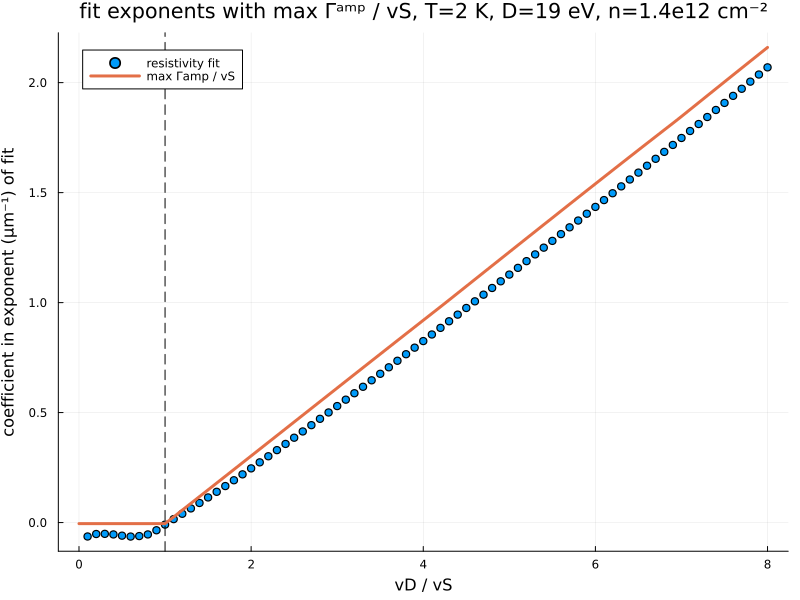

In [406]:
# p8 = scatter(s_vals.*(r_LA*vF*1e-5), log_resistivity_fit_params[:,2], label = "resistivity fit")
# p8 = plot!(s_vals.*(r_LA*vF*1e-5), expected_slopes, label = "max Γamp / vS", linewidth=3)
# p8 = vline!([21], linestyle=:dash, color=:black, label=:none)
# p8 = plot!(xlabel="vD (km/s)", ylabel="coefficient in slope (1/μm) of fit")
p8 = scatter(s_vals, log_resistivity_fit_params[:,2], label = "resistivity fit")
p8 = plot!(s_vals, expected_slopes, label = "max Γamp / vS", linewidth=3)
p8 = vline!([1], linestyle=:dash, color=:black, label=:none)
p8 = plot!(xlabel="vD / vS", ylabel="coefficient in exponent (μm⁻¹) of fit")
p8 = plot!(title="fit exponents with max Γᵃᵐᵖ / vS, T=2 K, D=19 eV, n=1.4e12 cm⁻²", legend=:topleft)
p8 = plot!(size=(800,600))

resistivity plot for pub:

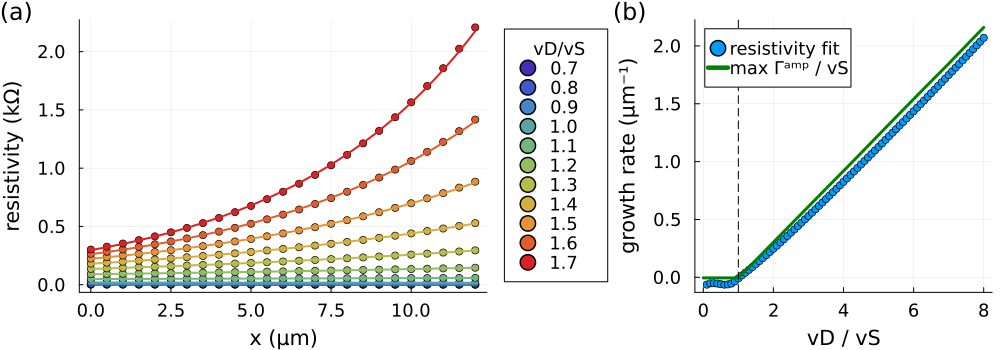

In [407]:
plot_indices = 8:18

colors = [get(ColorSchemes.rainbow, i./size(plot_indices,1)) for i in eachindex(plot_indices)]

sp1 = scatter(x_vals_μm, ([eachrow(resistivities)...])[plot_indices]./1e3, labels=hcat(s_vals[plot_indices]...), color=colors')
sp1 = plot!(x_finer_grid_μm, [x -> exp(model(x, log_resistivity_fit_params[i,:]))./1e3 for i=plot_indices], labels=:none, color=colors', linewidth=2)
sp1 = plot!(xlabel = "x (μm)", ylabel = "resistivity (kΩ)", legendtitle="vD/vS", legend=:outerright)
sp1 = plot!(tickfontsize=12, labelfontsize=14, legendfontsize=12, legendtitlefontsize=12)

sp2 = scatter(s_vals, log_resistivity_fit_params[:,2], label = "resistivity fit")
sp2 = plot!(s_vals, expected_slopes, label = "max Γᵃᵐᵖ / vS", linewidth=3, color=:green)
sp2 = vline!([1], linestyle=:dash, color=:black, label=:none)
sp2 = plot!(xlabel="vD / vS", ylabel="growth rate (μm⁻¹)")
sp2 = plot!(legend=:topleft)
sp2 = plot!(tickfontsize=12, labelfontsize=14, legendfontsize=12)


l = @layout [ a{0.64w} b ]
p = plot(sp1, sp2, layout=l, left_margin=5*Plots.mm, bottom_margin=6*Plots.mm, top_margin=3*Plots.mm, right_margin=0*Plots.mm)
p = annotate!(-19.6,2.3,text("(a)",16), subplot=2)
p = annotate!(-2.1,2.3,text("(b)",16), subplot=2)
p = plot!(size=(1000,350))

In [408]:
savefig(p,"./figs/for_pub/resistivity.svg")

"c:\\Users\\eric0\\Documents\\uci\\research ii\\phonon_amp_git_ver\\phonon-amp\\figs\\for_pub\\resistivity.svg"

now for the $\Gamma^\textrm{amp}$ plots...

In [409]:
function γs_df_to_Γamp_dict(γs_df)
    d = Dict{Tuple{Float64,Float64},Float64}()
    for row in eachrow(γs_df)
        qx,qy = row[1],row[2]
        Γamp = row[6]
        d[qx,qy] = Γamp
    end
    return d
end

function Γamp_interp(γs_dict)
    qx_dict_vec = union(sort([key[1] for key in keys(γs_dict)]))
    qx_dict_range = range(qx_dict_vec[1],qx_dict_vec[end],length=size(qx_dict_vec,1))
    qy_dict_vec = union(sort([key[2] for key in keys(γs_dict)]))
    qy_dict_range = range(qy_dict_vec[1],qy_dict_vec[end],length=size(qy_dict_vec,1))
    Γamp_vals = [γs_dict[qx,qy] for qx in qx_dict_range, qy in qy_dict_range]
    Γamp_interp = linear_interpolation((qx_dict_range,qy_dict_range), Γamp_vals)
    return Γamp_interp
end

Γamp_interp (generic function with 1 method)

In [410]:
s1::Float64 = 0.9
γs1 = load_γs_df_2K(n,s1)
Γamps1 = γs_df_to_Γamp_dict(γs1)
interp1 = Γamp_interp(Γamps1)

s2::Float64 = 1.1
γs2 = load_γs_df_2K(n,s2)
Γamps2 = γs_df_to_Γamp_dict(γs2)
interp2 = Γamp_interp(Γamps2)

s3::Float64 = 2.0
γs3 = load_γs_df_2K(n,s3)
Γamps3 = γs_df_to_Γamp_dict(γs3)
interp3 = Γamp_interp(Γamps3)

s4::Float64 = 5.0
γs4 = load_γs_df_2K(n,s4)
Γamps4 = γs_df_to_Γamp_dict(γs4)
interp4 = Γamp_interp(Γamps4)



maxΓ1 = maximum(abs.(values(Γamps1))) * 1e-9
maxΓ2 = maximum(abs.(values(Γamps2))) * 1e-9
maxΓ3 = maximum(abs.(values(Γamps3))) * 1e-9
maxΓ4 = maximum(abs.(values(Γamps4))) * 1e-9
maxΓ = max(maxΓ1,maxΓ2,maxΓ3,maxΓ4)

38.439918352030574

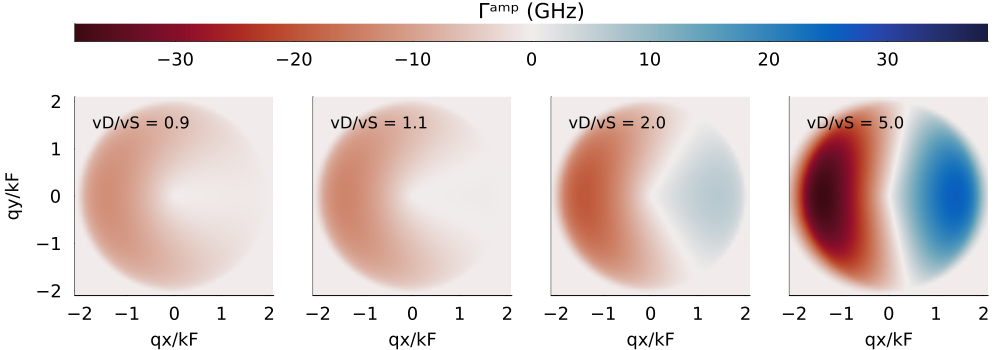

In [428]:
# qvals = hcat(collect.(collect(keys(Γamps1)))...)
# qx_plot_vals = range(minimum(qvals[1,:]), maximum(qvals[1,:]), length=1000)
# qy_plot_vals = range(minimum(qvals[2,:]), maximum(qvals[2,:]), length=1000)
qx_plot_vals = range(-2.1,2.1,length=1000)
qy_plot_vals = range(-2.1,2.1,length=1000)

colormap = cgrad(:balance, rev=true)

sp1 = heatmap(qx_plot_vals, qy_plot_vals, (qx,qy) -> interp1(qx,qy) * 1e-9, cmap=colormap, clims=(-maxΓ,maxΓ))
sp1 = plot!(legend=:topleft, legendtitle=@sprintf("vD/vS = %1.1f",s1), legend_background_color=:transparent, legend_foreground_color=:transparent)
sp1 = plot!(aspect_ratio=:equal, xlims=(minimum(qx_plot_vals),maximum(qx_plot_vals)), ylims=(minimum(qy_plot_vals),maximum(qy_plot_vals)))
sp1 = plot!(colorbar=false, tickfontsize=12, ylabel="qy/kF", labelfontsize=12, xlabel="qx/kF", legendfontsize=12)

sp2 = heatmap(qx_plot_vals, qy_plot_vals, (qx,qy) -> interp2(qx,qy) * 1e-9, cmap=colormap, clims=(-maxΓ,maxΓ))
sp2 = plot!(legend=:topleft, legendtitle=@sprintf("vD/vS = %1.1f",s2), legend_background_color=:transparent, legend_foreground_color=:transparent)
sp2 = plot!(aspect_ratio=:equal, xlims=(minimum(qx_plot_vals),maximum(qx_plot_vals)), ylims=(minimum(qy_plot_vals),maximum(qy_plot_vals)))
sp2 = plot!(colorbar=false, tickfontsize=12, yticks=:none, xlabel="qx/kF", labelfontsize=12, legendfontsize=12)

sp3 = heatmap(qx_plot_vals, qy_plot_vals, (qx,qy) -> interp3(qx,qy) * 1e-9, cmap=colormap, clims=(-maxΓ,maxΓ))
sp3 = plot!(legend=:topleft, legendtitle=@sprintf("vD/vS = %1.1f",s3), legend_background_color=:transparent, legend_foreground_color=:transparent)
sp3 = plot!(aspect_ratio=:equal, xlims=(minimum(qx_plot_vals),maximum(qx_plot_vals)), ylims=(minimum(qy_plot_vals),maximum(qy_plot_vals)))
sp3 = plot!(colorbar=false, tickfontsize=12, yticks=:none, xlabel="qx/kF", labelfontsize=12, legendfontsize=12)

sp4 = heatmap(qx_plot_vals, qy_plot_vals, (qx,qy) -> interp4(qx,qy) * 1e-9, cmap=colormap, clims=(-maxΓ,maxΓ))
sp4 = plot!(legend=:topleft, legendtitle=@sprintf("vD/vS = %1.1f",s4), legend_background_color=:transparent, legend_foreground_color=:transparent)
sp4 = plot!(aspect_ratio=:equal, xlims=(minimum(qx_plot_vals),maximum(qx_plot_vals)), ylims=(minimum(qy_plot_vals),maximum(qy_plot_vals)))
sp4 = plot!(colorbar=false, tickfontsize=12, yticks=:none, xlabel="qx/kF", labelfontsize=12, legendfontsize=12)

cb = heatmap(range(-maxΓ,maxΓ,length=1000),[1], (x,y)->x, cmap=colormap, clims=(-maxΓ,maxΓ), yticks=:none, title="Γᵃᵐᵖ (GHz)", colorbar=false, tickfontsize=12, labelfontsize=12)

l = @layout [ a{0.07h }; grid(1,4) ]
p = plot(cb,sp1,sp2,sp3,sp4, layout=l)
p = plot!(left_margin=5*Plots.mm)
p = plot!(size=(1000,350))

In [429]:
savefig(p,"./figs/for_pub/gamma_amp_cones.svg")

"c:\\Users\\eric0\\Documents\\uci\\research ii\\phonon_amp_git_ver\\phonon-amp\\figs\\for_pub\\gamma_amp_cones.svg"

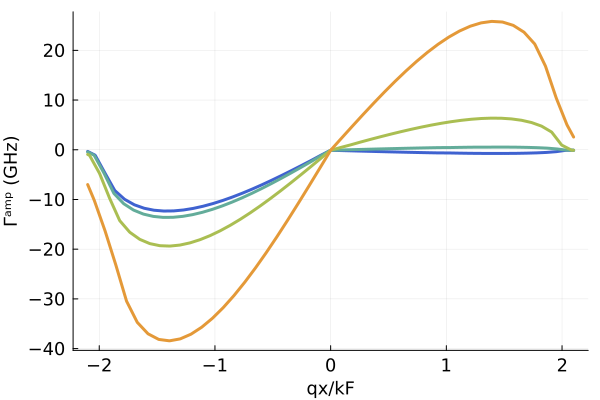

In [412]:
s_vals = [s1,s2,s3,s4,10.0]
colors = [get(ColorSchemes.rainbow, i./size(s_vals,1)) for i in eachindex(s_vals)]

qx_plot_vals = range(-2.1,2.1,length=1000)
sp1 = plot()
for (i,s) in enumerate(s_vals[1:4])
    γs = load_γs_df_2K(n,s)
    Γamps = γs_df_to_Γamp_dict(γs)
    interp = Γamp_interp(Γamps)
    sp1 = plot!(qx_plot_vals, interp.(qx_plot_vals, 0.0) .* 1e-9, label=s, linewidth=3, color=colors[i])
end
sp1 = plot!(xlabel="qx/kF", ylabel="Γᵃᵐᵖ (GHz)", legend=:none, tickfontsize=12, labelfontsize=12)

In [413]:
function load_γs_df_vary_n(n,s)
    T = 2.0
    T_str = @sprintf("%1.2e",T)
    n_str = @sprintf("%1.2e",n)
    s_str = @sprintf("%1.2e",s)
    return DataFrame(CSV.File("./amp_rates_csv/D_19_eV/vary_n/" * replace("T="*T_str*"_n="*n_str*"_s="*s_str, "."=>"-") * ".csv"))
end

function max_Γamp_df(n_vals, s_vals)
    # note that the first column, vD, is in cm/s, and the Γamps are in 1/s.
    T = 2.0 # K
    vS = r_LA*vF # this is in cm/s

    max_Γamp_df = DataFrame()
    max_Γamp_df."vD" = s_vals .* vS

    for n in n_vals
        current_n_array = Float64[]
        for s in s_vals
            γs_df = load_γs_df_vary_n(n,s)
            Γamps = γs_df."Γamp"
            max_Γamp = maximum(Γamps) # this is in 1/s
            push!(current_n_array, max_Γamp)
        end
        n_str = @sprintf("%1.2e",n)
        max_Γamp_df[!, Symbol(n)] = current_n_array
    end
    
    return max_Γamp_df
end

max_Γamp_df (generic function with 1 method)

In [414]:
n_vals = range(0.0, 3.0e12, length=21)[2:end] # cm^-2
s_vals = [0.9, 1.1, 2.0, 5.0, 10.0]

max_Γamps = max_Γamp_df(n_vals, s_vals)

5×21 DataFrame
 Row │ vD       1.5e11      3.0e11       4.5e11       6.0e11       7.5e11      ⋯
     │ Float64  Float64     Float64      Float64      Float64      Float64     ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1.89e6  -1.0e8      -1.0e8       -1.0e8       -1.0e8       -1.0e8      ⋯
   2 │  2.31e6  -3.08032e7   3.8299e7     1.07346e8    1.76365e8    2.45366e8
   3 │  4.2e6    5.92691e8   1.28569e9    1.97833e9    2.67077e9    3.3631e9
   4 │  1.05e7   2.67851e9   5.45874e9    8.23775e9    1.10161e10   1.37941e10
   5 │  2.1e7    6.16444e9   1.24246e10   1.86814e10   2.49366e10   3.11907e10 ⋯
                                                              15 columns omitted

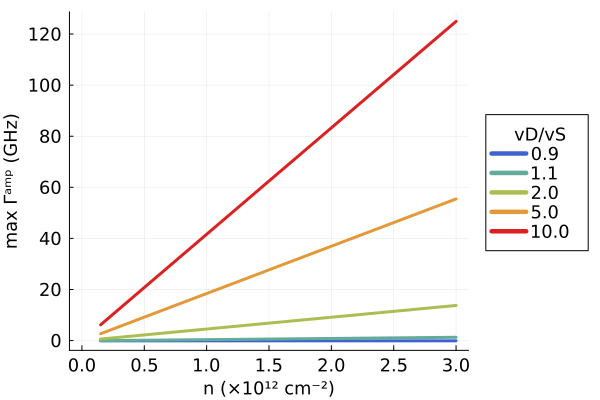

In [415]:
sp2 = plot()
for (i,s) in enumerate(s_vals)
    sp2 = plot!(n_vals ./ 1e12, collect(max_Γamps[i,2:end]) ./ 1e9, label=s, linewidth=3, color=colors[i])
end
sp2 = plot!(xlabel="n (×10¹² cm⁻²)", ylabel="max Γᵃᵐᵖ (GHz)", legendtitle="vD/vS", legend=:outerright)
sp2 = plot!(xlims=(-0.1,3.1), xticks=0.0:0.5:3.0, tickfontsize=12, labelfontsize=12, legendfontsize=12, legendtitlefontsize=12)

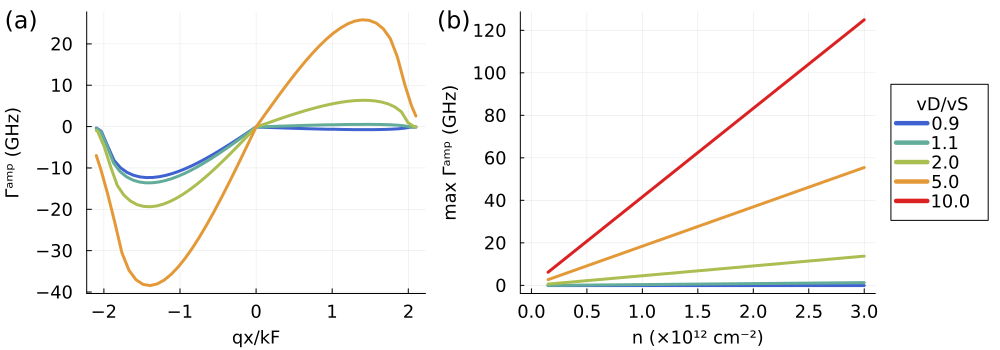

In [416]:
l = @layout [ a b{0.58w} ]
p = plot(sp1,sp2,layout=l)
p = plot!(bottom_margin=6*Plots.mm, left_margin=5*Plots.mm)
p = annotate!(-4.6,125,text("(a)",16), subplot=2)
p = annotate!(-0.7,125,text("(b)",16), subplot=2)
p = plot!(size=(1000,350))

In [417]:
savefig(p,"./figs/for_pub/gamma_amp_behavior.svg")

"c:\\Users\\eric0\\Documents\\uci\\research ii\\phonon_amp_git_ver\\phonon-amp\\figs\\for_pub\\gamma_amp_behavior.svg"